# Network traffic Prediction

## Install tensorflow  1.2 

In [3]:

!pip install -U tensorflow==1.2.0
!pip install -U keras


  Using cached tensorflow-1.2.0-cp35-cp35m-manylinux1_x86_64.whl
Requirement already up-to-date: numpy>=1.11.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sffc-3691fbb0f320c6-8c20818cd6ff/.local/lib/python3.5/site-packages (from tensorflow==1.2.0)
Requirement already up-to-date: six>=1.10.0 in /usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages (from tensorflow==1.2.0)
Requirement already up-to-date: protobuf>=3.1.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sffc-3691fbb0f320c6-8c20818cd6ff/.local/lib/python3.5/site-packages (from tensorflow==1.2.0)
Requirement already up-to-date: wheel>=0.26 in /usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages (from tensorflow==1.2.0)
Requirement already up-to-date: setuptools in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sffc-3691fbb0f320c6-8c20818cd6ff/.local/lib/python3.5/site-packages (from protobuf>=3.1.0->tensorflow==1.2.0)
Exception:
Traceback (most recent call last):
  File "/usr/local/src/conda3

In [4]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## load data from swift object storage 

In [5]:

from io import StringIO
import requests
import json
import pandas as pd

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def load_files(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_075c73a8606206b6b47033f254530e4ff9d3a88d','domain': {'id': 'bab319d38dc849dcad35fe38bd16dbdf'},
            'password': 'cOg{cWr86]Nm(.mV'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)


In [6]:
data_files=['env5_brain_192.155.247.207_20170401_20170601.csv',
            'env5_brain_169.55.245.30_20170401_20170601.csv',
            'env5_brain_169.54.213.198_20170401_20170601.csv',
            'env5_brain_10.143.131.55_20170401_20170601.csv',
            'env5_brain_10.143.123.125_20170401_20170601.csv',
            'env5_brain_10.107.77.247_20170401_20170601.csv']
data_files1=['env5_brain_10.107.77.247_20170401_20170601.csv']

17317
(17542, 3)
17446
(17544, 3)
17472
(17544, 3)
17446
(17544, 3)
17472
(17544, 3)
17317
(17542, 3)


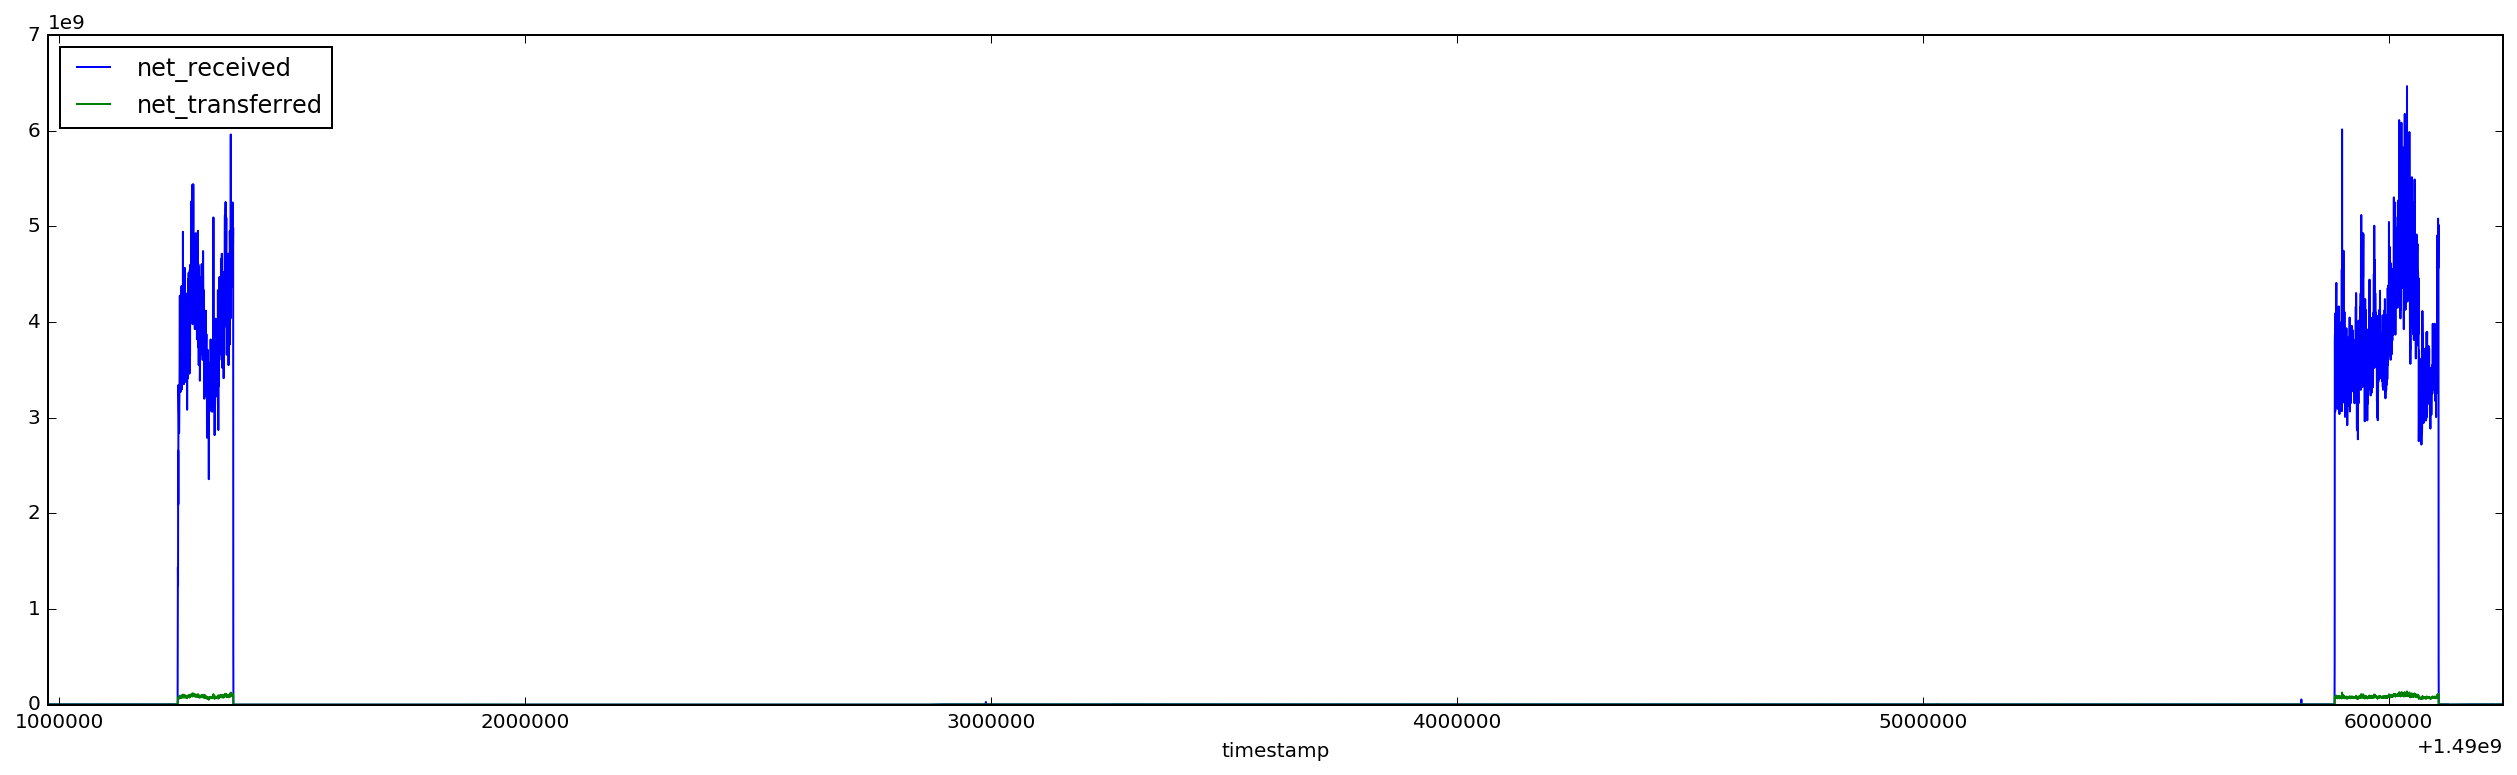

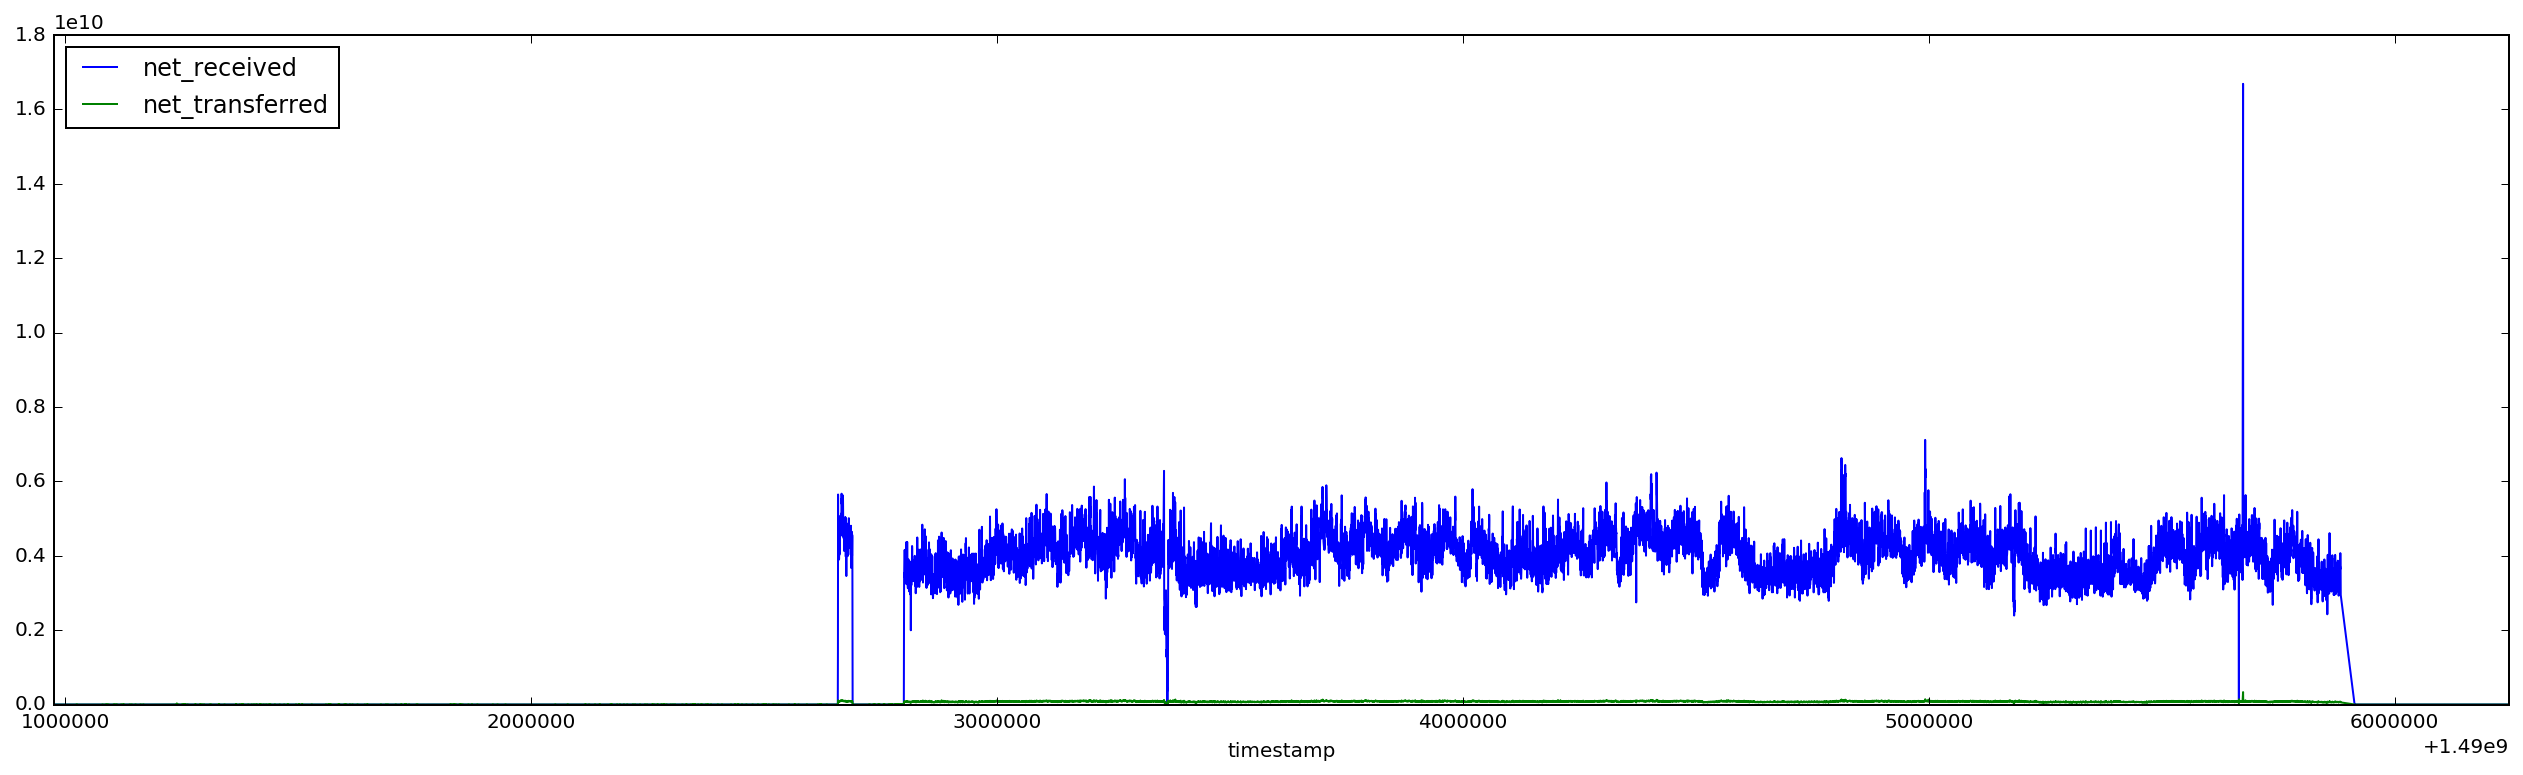

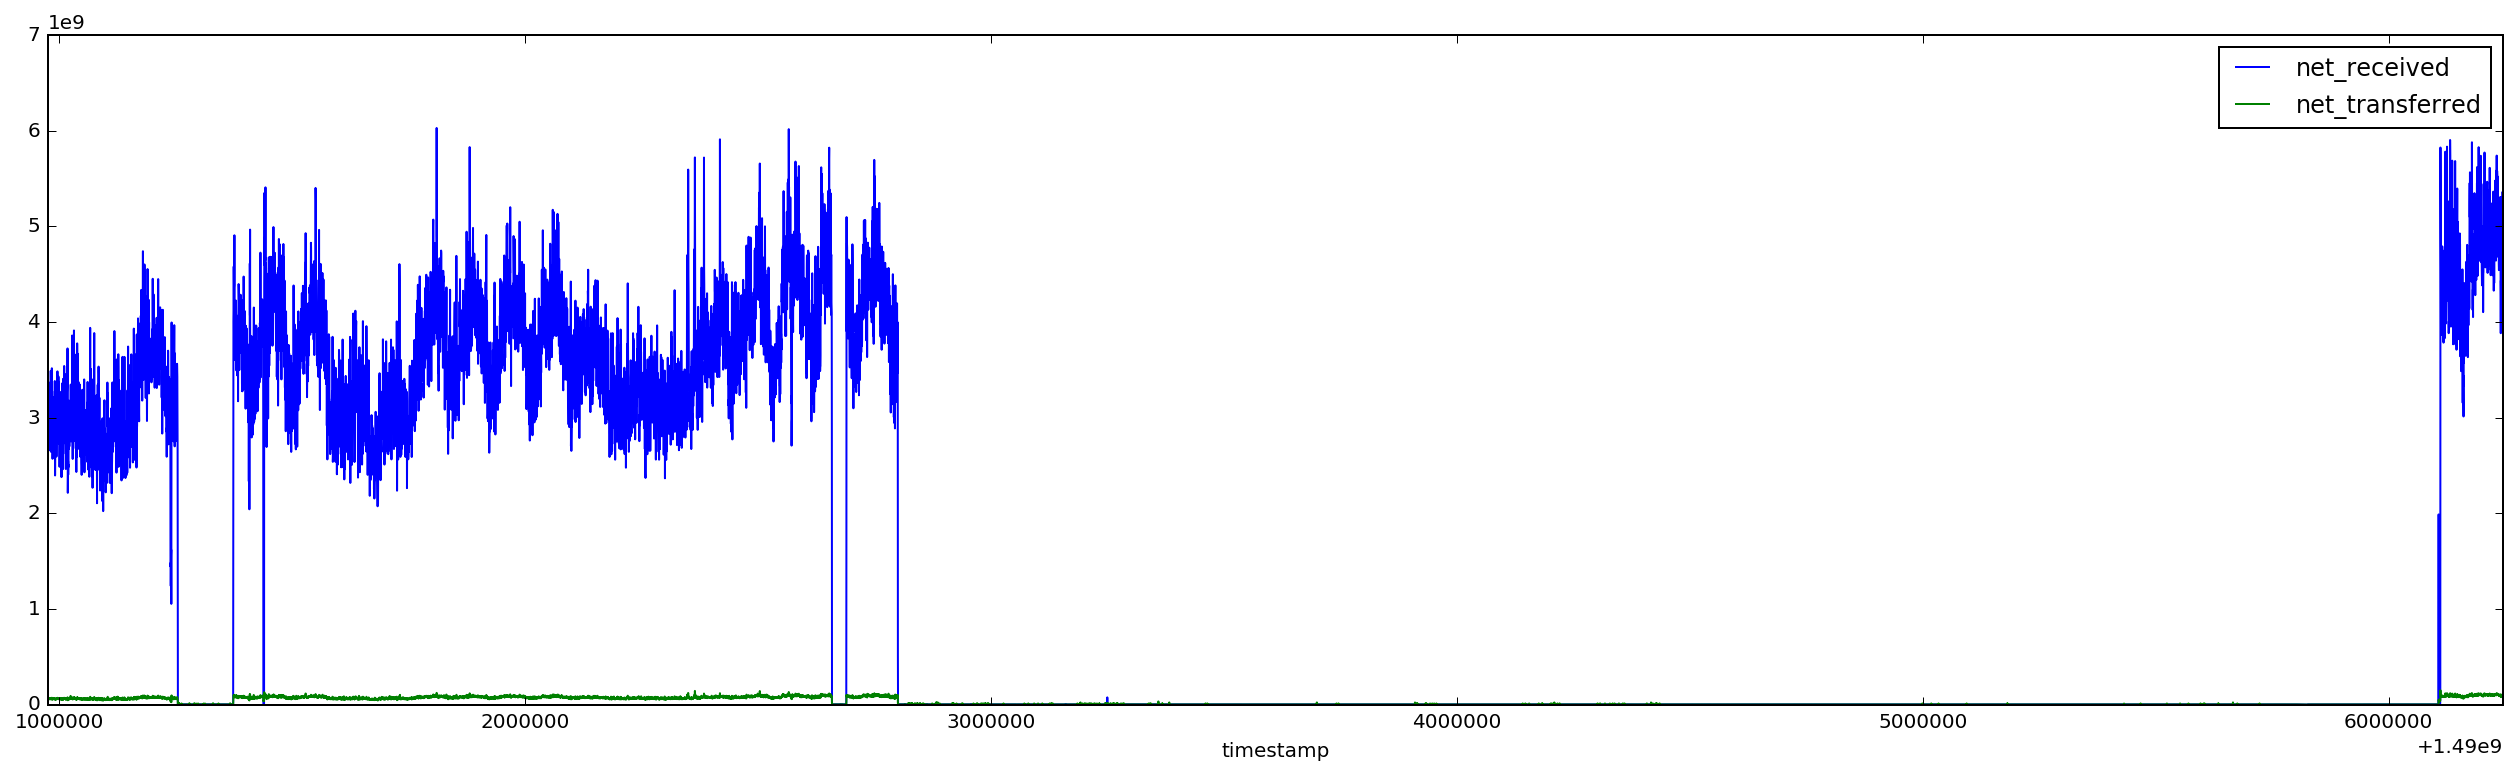

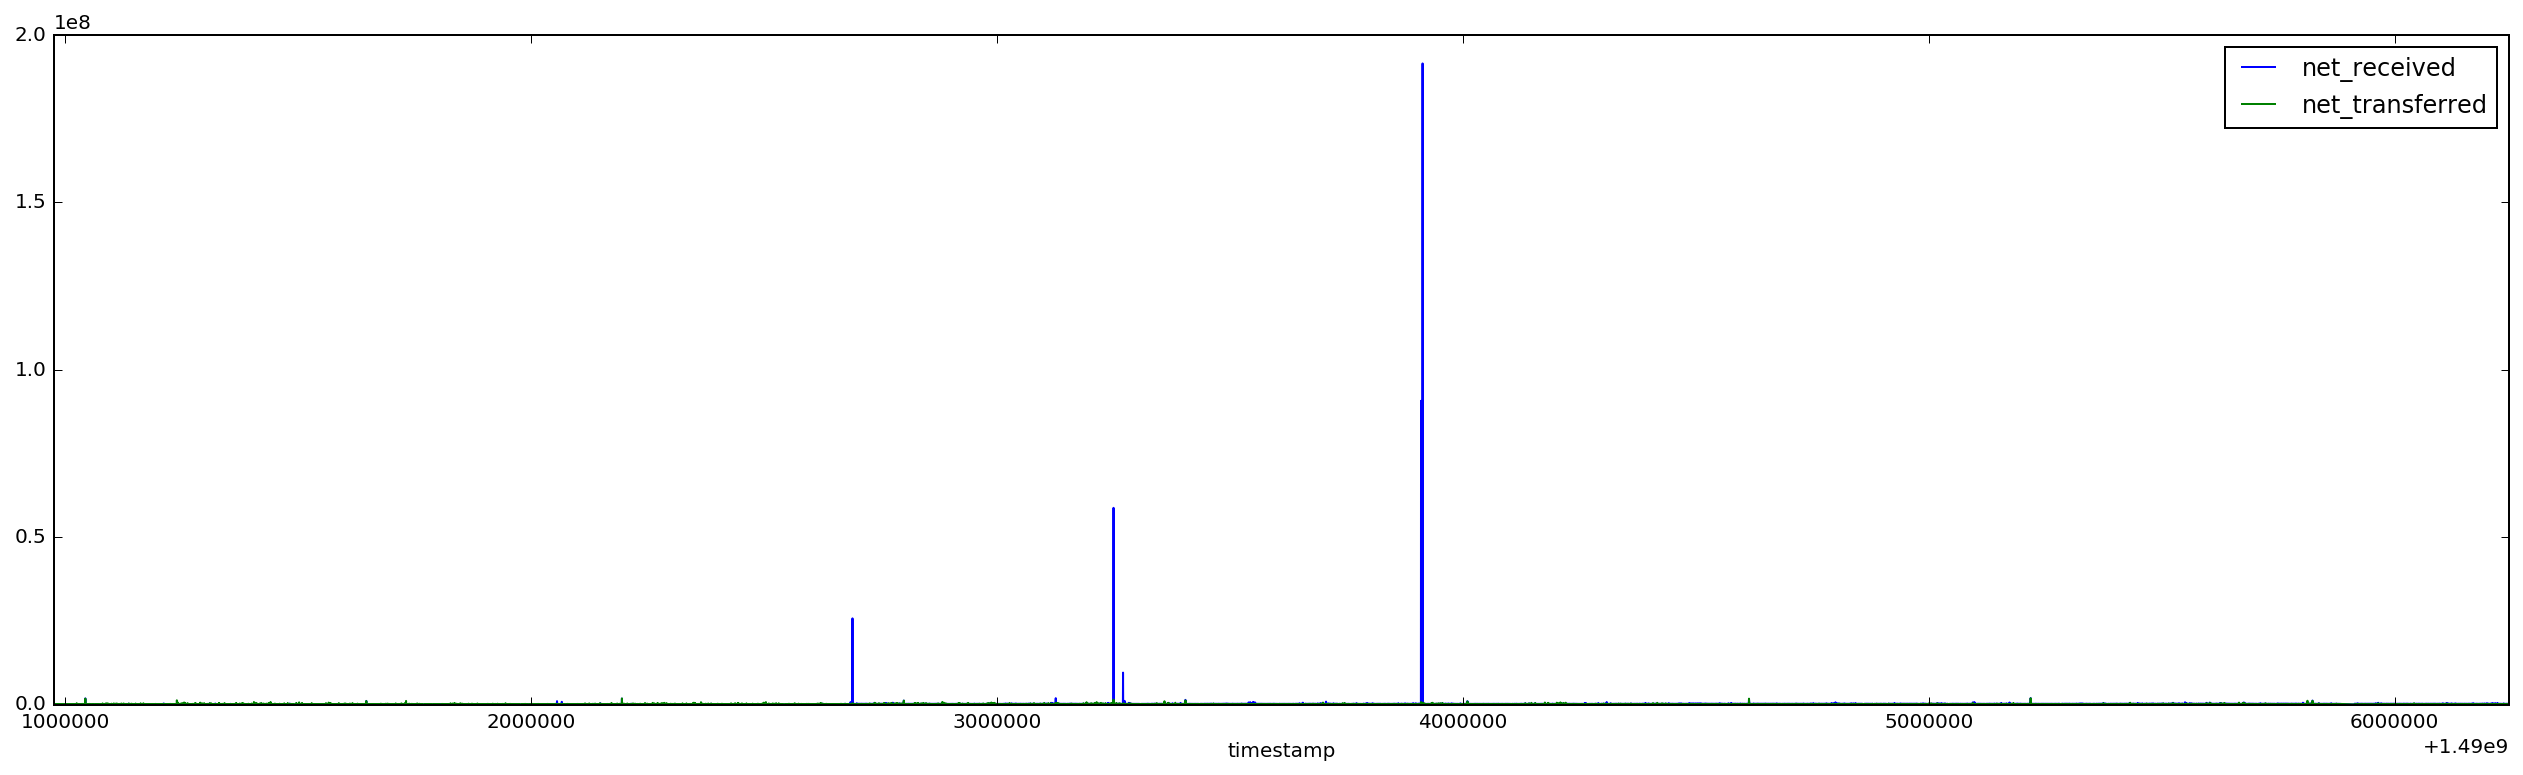

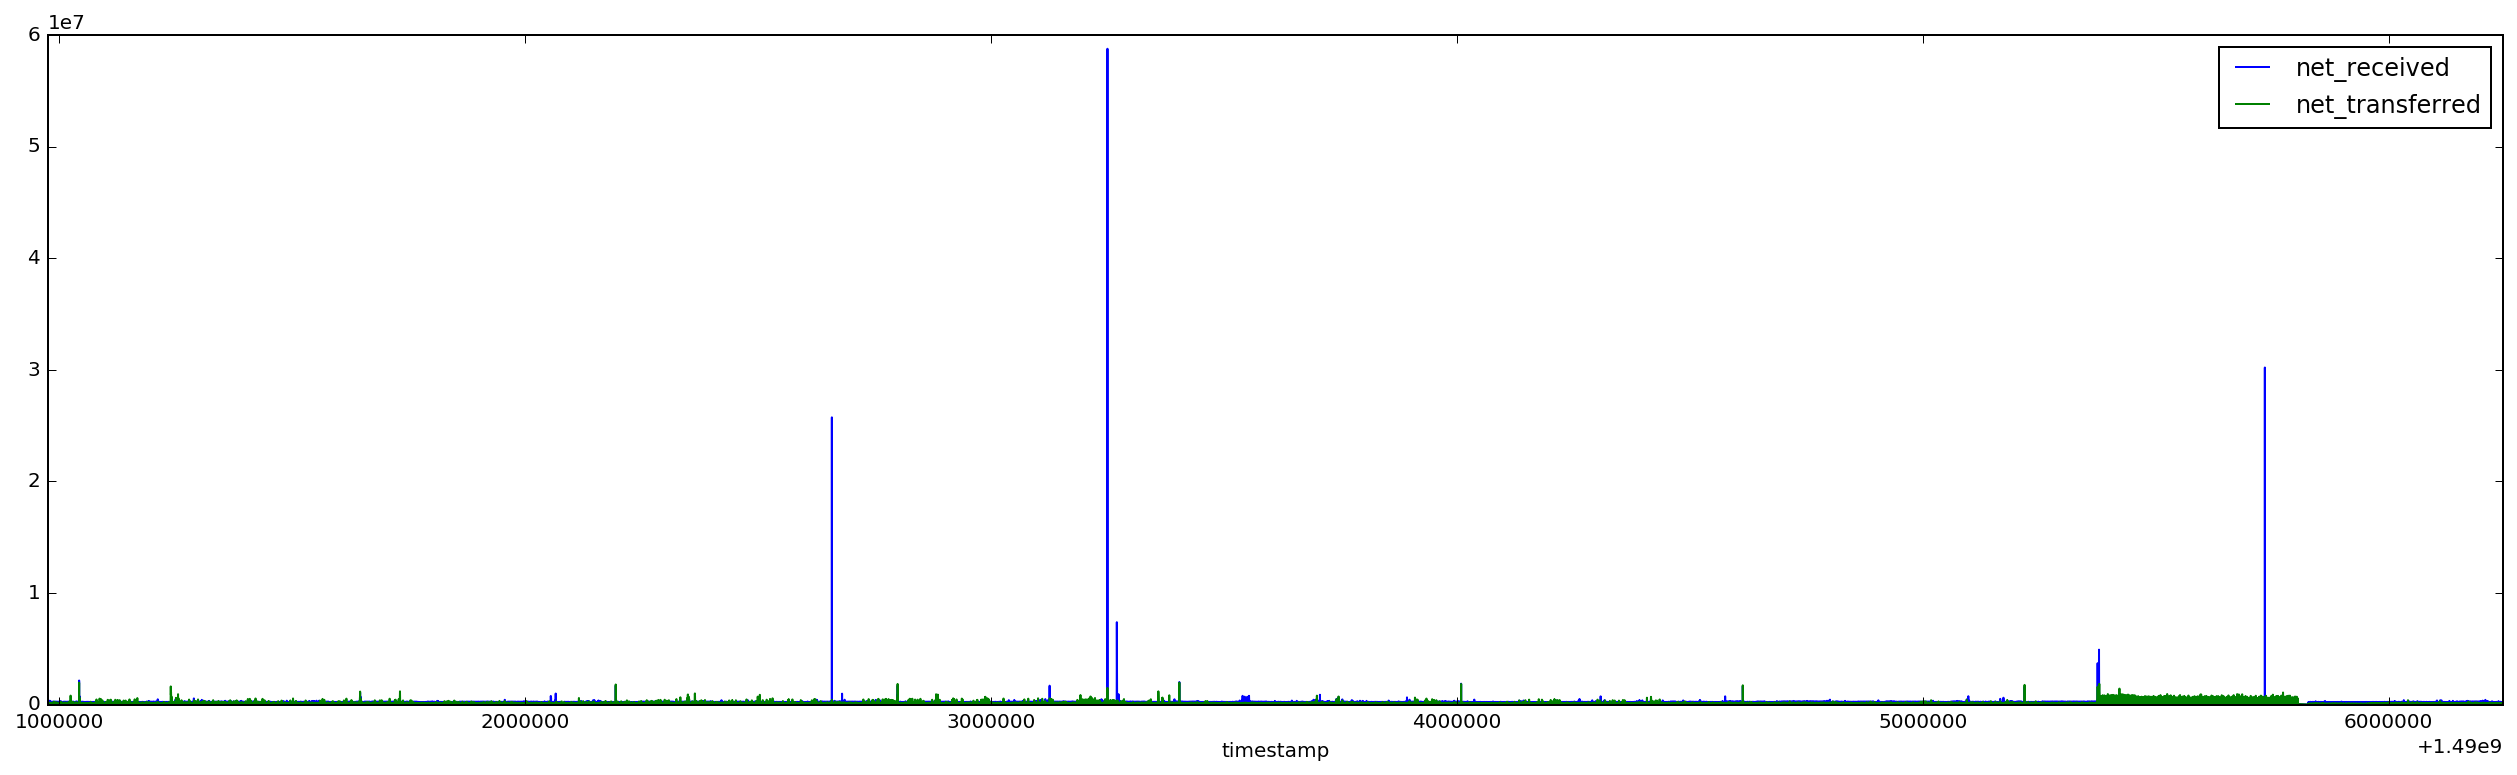

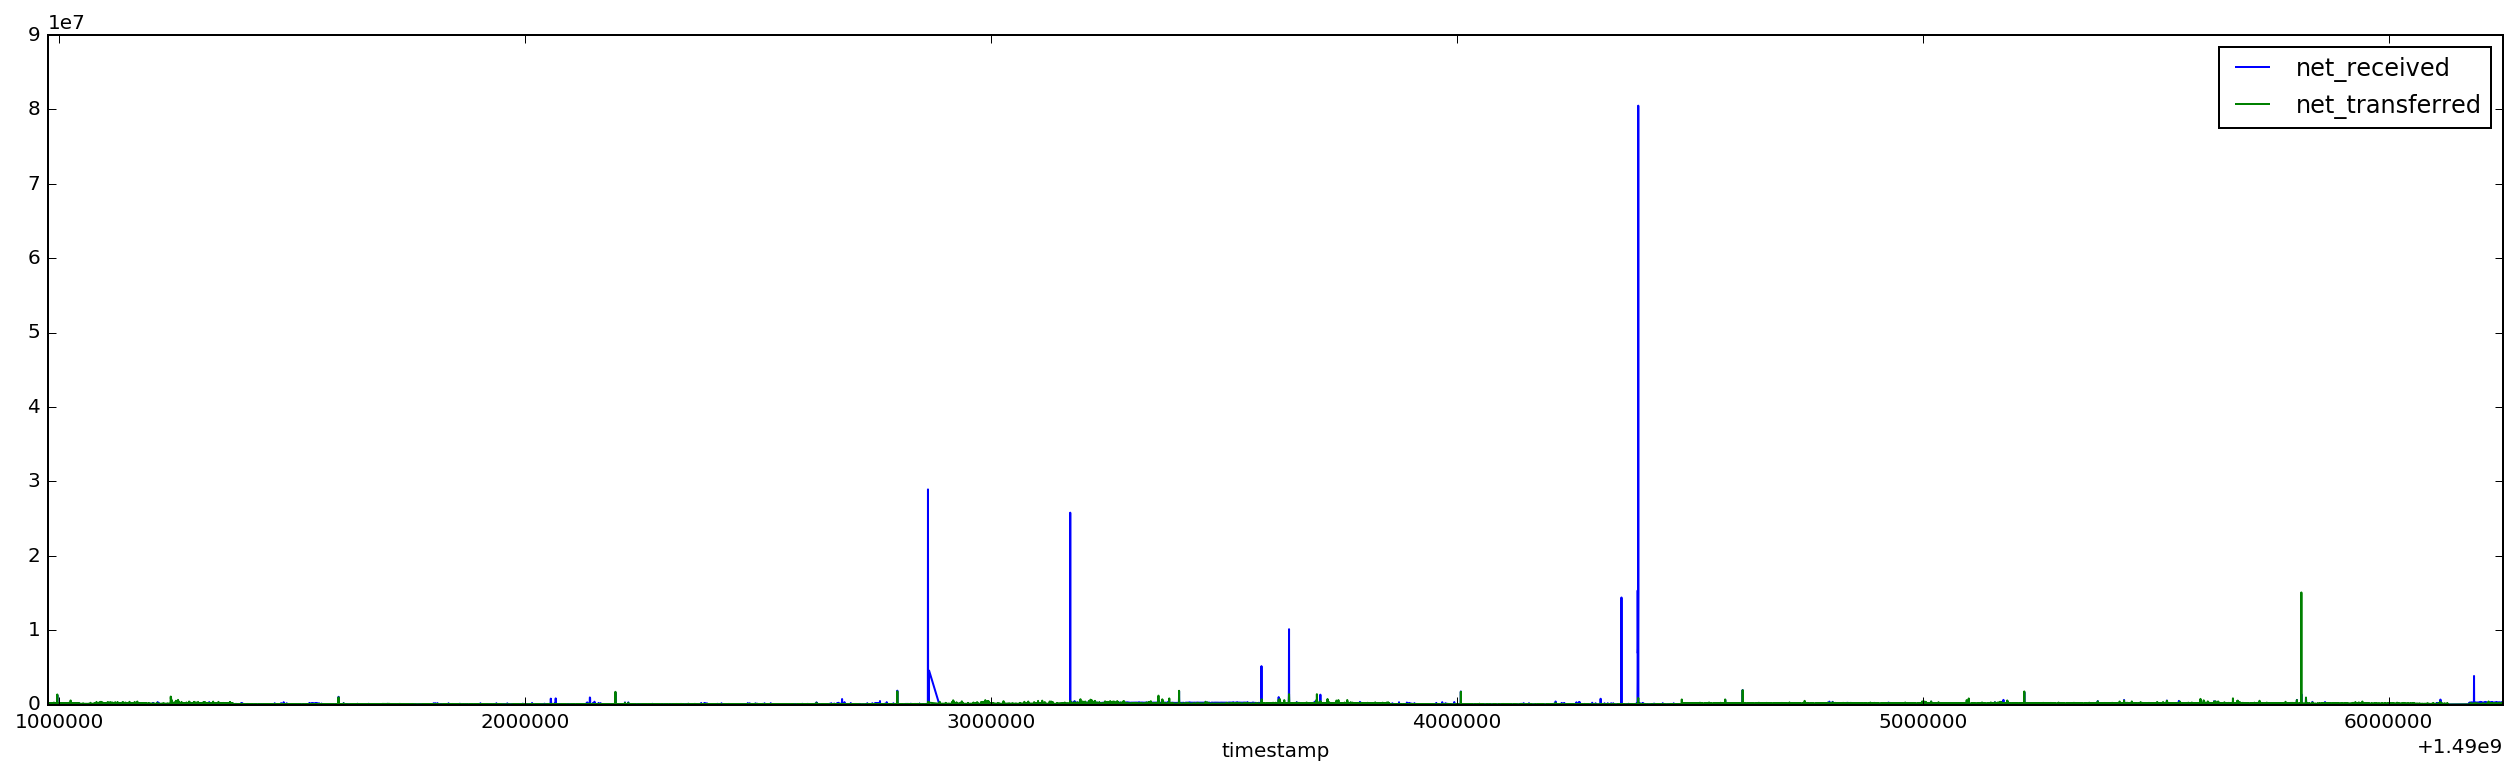

In [7]:
for data_file in data_files:
    src_data = pd.read_csv(load_files('DefaultProjectjiamaocnibmcom', data_file))
    #src_data.head()
    src_data.plot(x='timestamp',figsize=(22,6))
    input=np.empty(shape=(0,3))
    first_row= True
    previous_timestamp=0
    #print(src_data.iloc(src_data.shape[0]))
    i=0
    for index, row in src_data.iterrows():
        current_timestamp=row['timestamp']
        if first_row:
            first_row= False
            previous_timestamp=current_timestamp
        else:
            #print('-----',current_timestamp)
            interval=current_timestamp-previous_timestamp
            if interval<300:
                print('incorrect interval',current_timestamp,previous_timestamp,interval)
            elif interval>=300 and interval<400:
                input=np.append(input,[[current_timestamp,row['net_received'],row['net_transferred']]],axis=0)
                #print('normal interval',current_timestamp,previous_timestamp,interval)
            elif interval>=400:
                while interval>=400:
                    #print('there is gap and generate new data',current_timestamp,previous_timestamp,interval)
                    #print(row['net_received'],row['net_transferred'])
                    previous_timestamp=previous_timestamp+300

                    input=np.append(input,[[previous_timestamp,0,0]],axis=0)
                    interval=current_timestamp-previous_timestamp
            previous_timestamp=current_timestamp
        i=i+1
    print(i)
    print(input.shape)
    #print(input)
        

In [8]:
dataframes=[]
for data_file in data_files:
    dataframes.append(pd.read_csv(load_files('DefaultProjectjiamaocnibmcom', data_file)))
timestamps=set()
for data in dataframes:
    for t in (data['timestamp']):
        timestamps.add(t)
    #print(type(data['timestamp']))
    #timestamps.add(data['timestamp'])
ts=sorted(timestamps)


In [9]:
s_input=np.empty(shape=(0,2))
for t in ts:
    sum_received=0
    sum_transferred=0
    for data in dataframes:
        i=data[data['timestamp']==t]
        cur_received=i.get('net_received',0)
        cur_transfer=i.get('net_transferred',0)
        for ind in cur_transfer.index:
            sum_transferred+=cur_transfer[ind]
        for ind in cur_received.index:
            sum_received+=cur_received[ind]
    s_input=np.append(s_input,[[sum_received,sum_transferred]],axis=0)
print(s_input)


[[  3.23829906e+09   6.92302500e+07]
 [  2.98978194e+09   6.49355350e+07]
 [  2.72662850e+09   5.98400170e+07]
 ..., 
 [  3.89577671e+09   8.49461070e+07]
 [  4.67576506e+09   9.98608080e+07]
 [  4.35472312e+09   9.27667460e+07]]


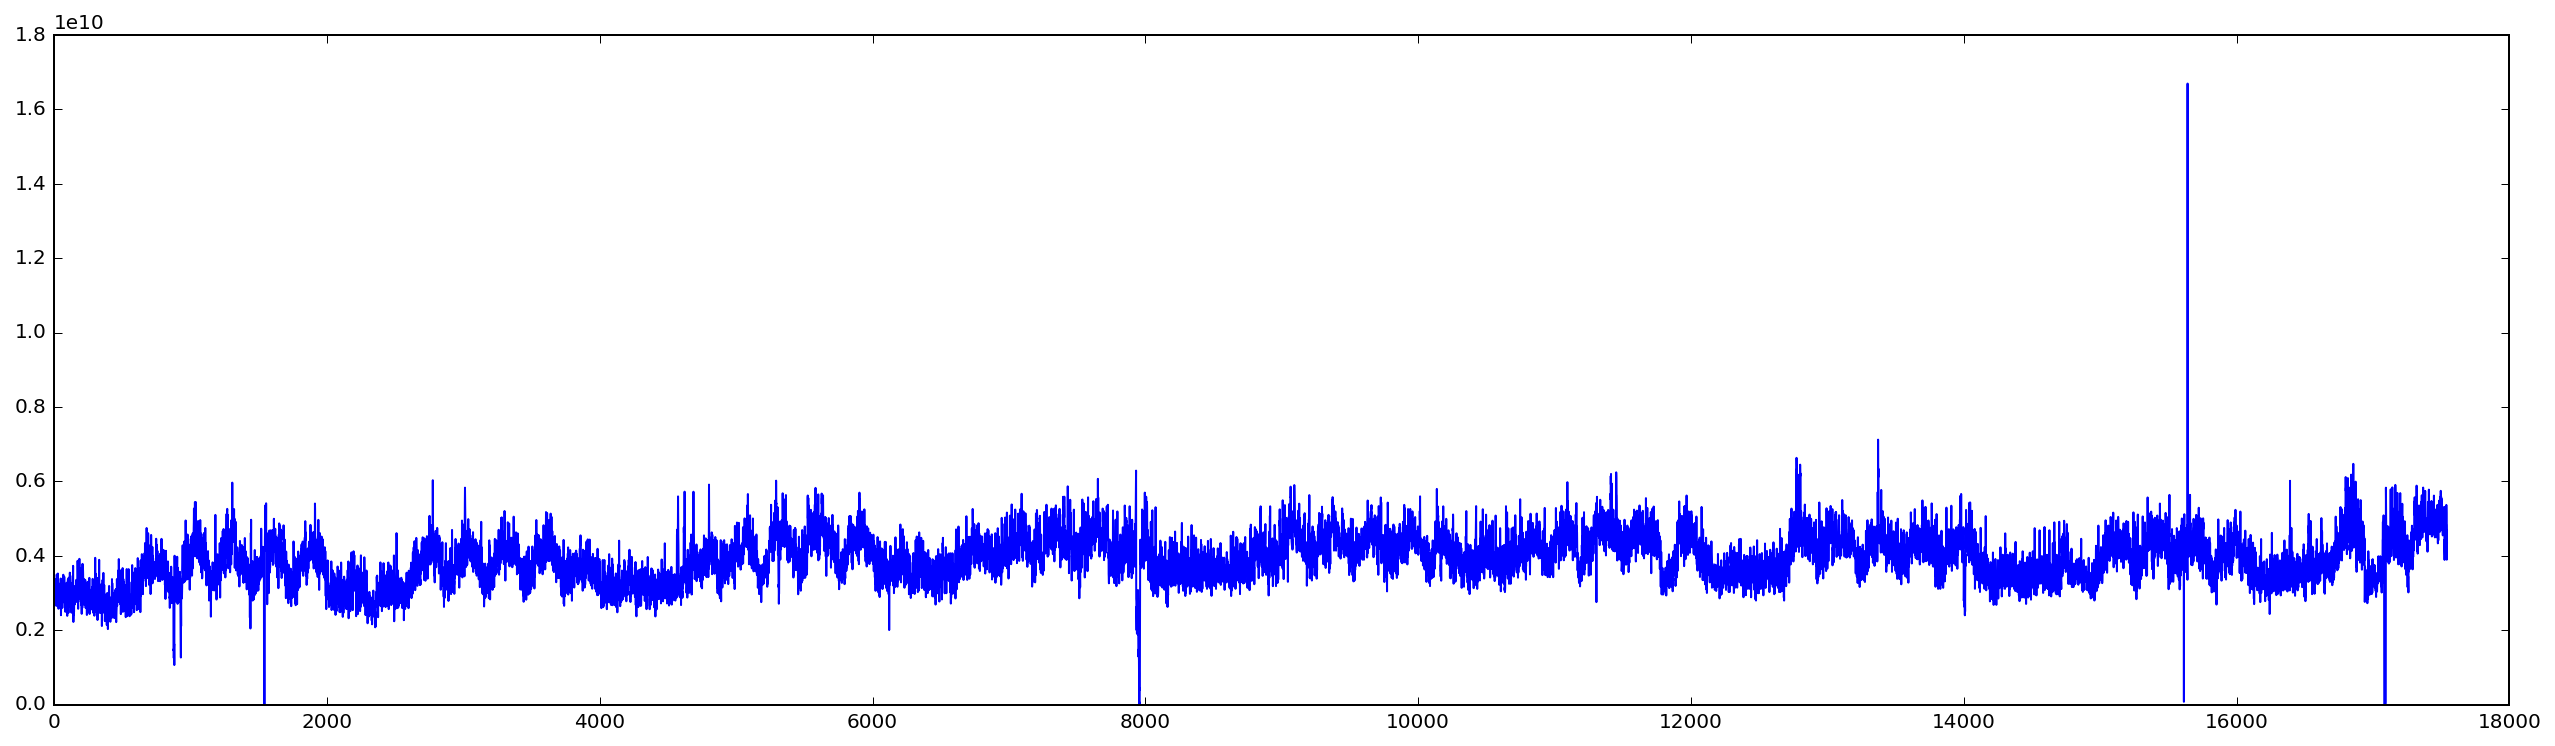

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,6), dpi=80)
plt.plot(s_input[:,0:1])

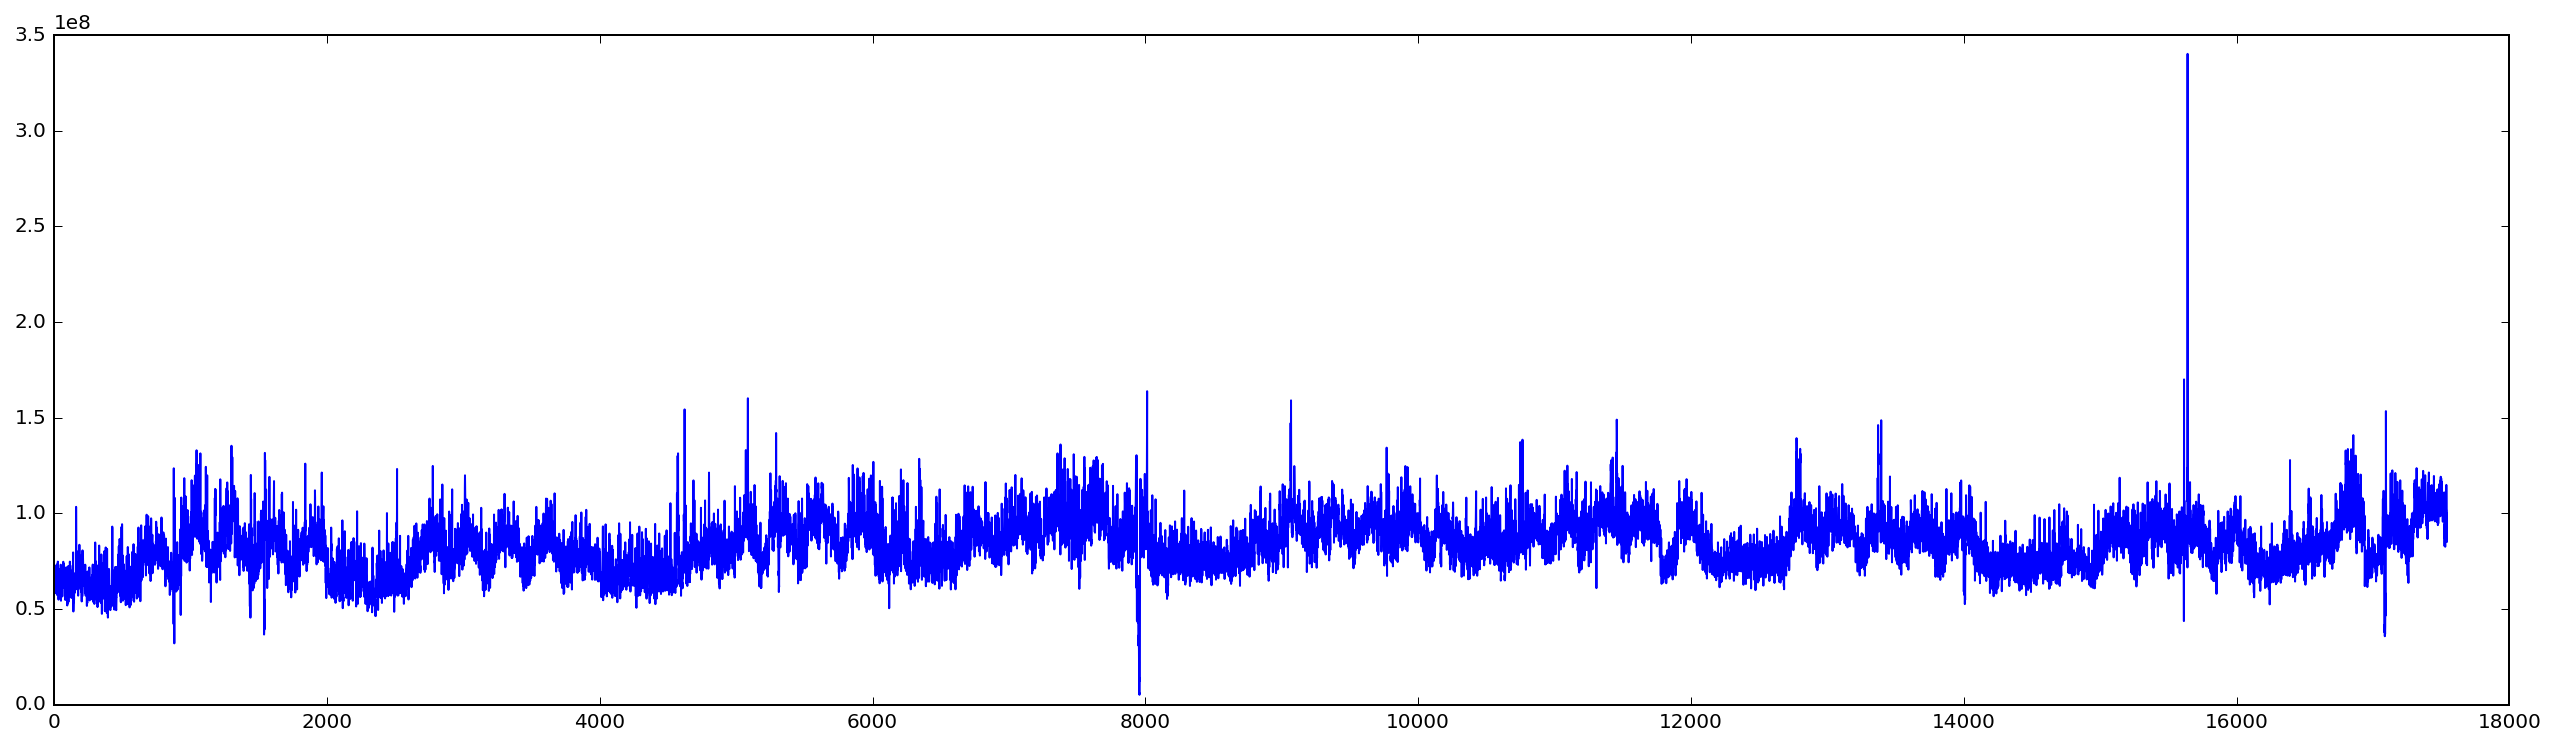

In [11]:
plt.figure(figsize=(22,6), dpi=80)

plt.plot(s_input[:,1:2])

## Compute Hourly Network traffic

In [12]:
hourly_input=np.empty(shape=(0,2))
size=s_input.shape[0]
for i in range(0,size,12):
    slice=s_input[i:i+12,:]
    hourly_rev=0
    hourly_transfer=0
    for s in slice:
        hourly_rev+=s[0]
        hourly_transfer=s[1]
    hourly_input=np.append(hourly_input,[[hourly_rev,hourly_transfer]],axis=0)

        

In [13]:
!pip install -U keras


Requirement already up-to-date: keras in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sffc-3691fbb0f320c6-8c20818cd6ff/.local/lib/python3.5/site-packages
Requirement already up-to-date: pyyaml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sffc-3691fbb0f320c6-8c20818cd6ff/.local/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: theano in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sffc-3691fbb0f320c6-8c20818cd6ff/.local/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: six in /usr/local/src/conda3_runtime.v11/4.1.1/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sffc-3691fbb0f320c6-8c20818cd6ff/.local/lib/python3.5/site-packages (from theano->keras)
Requirement already up-to-date: scipy>=0.14 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sffc-3691fbb0f320c6-8c20818cd6ff/.local/lib/python3.5/site-packages (from theano->keras)


In [ ]:
plt.figure(figsize=(22,6), dpi=80)

plt.plot(hourly_input)

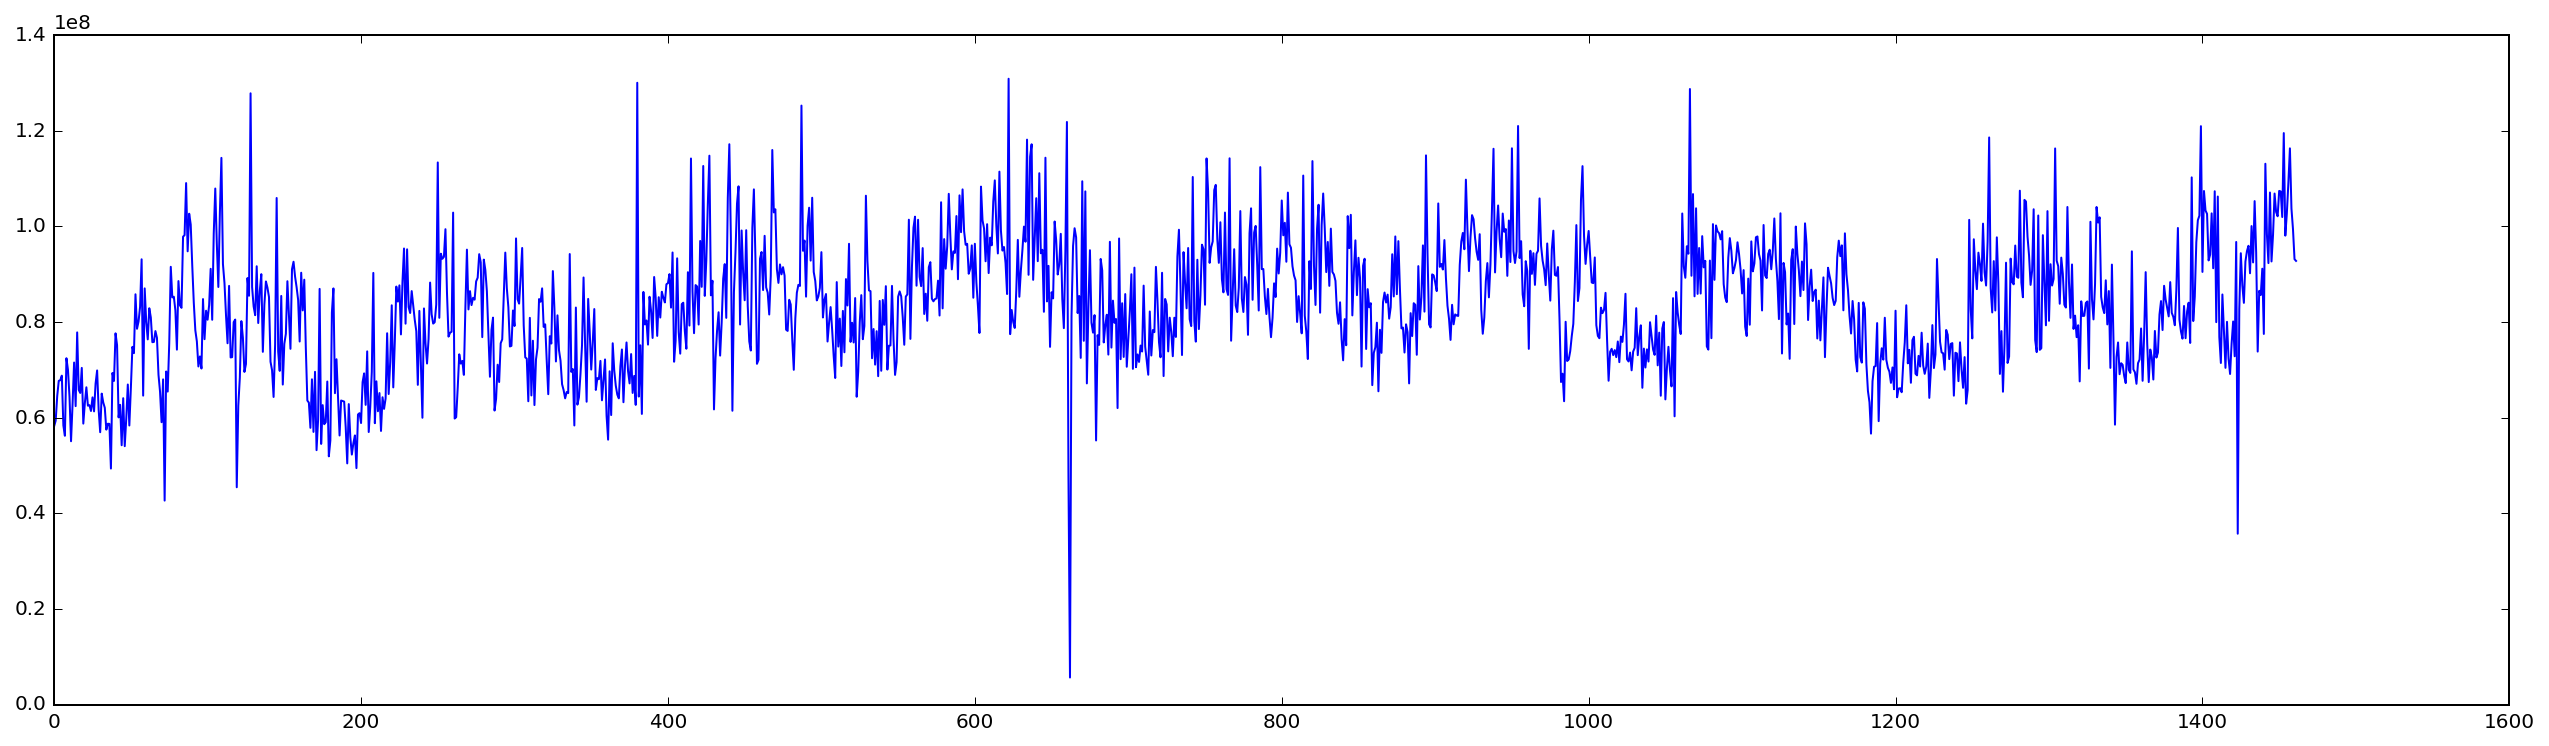

In [15]:
plt.figure(figsize=(22,6), dpi=80)

plt.plot(hourly_input[:,1:2])

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(hourly_input[:,0:1])


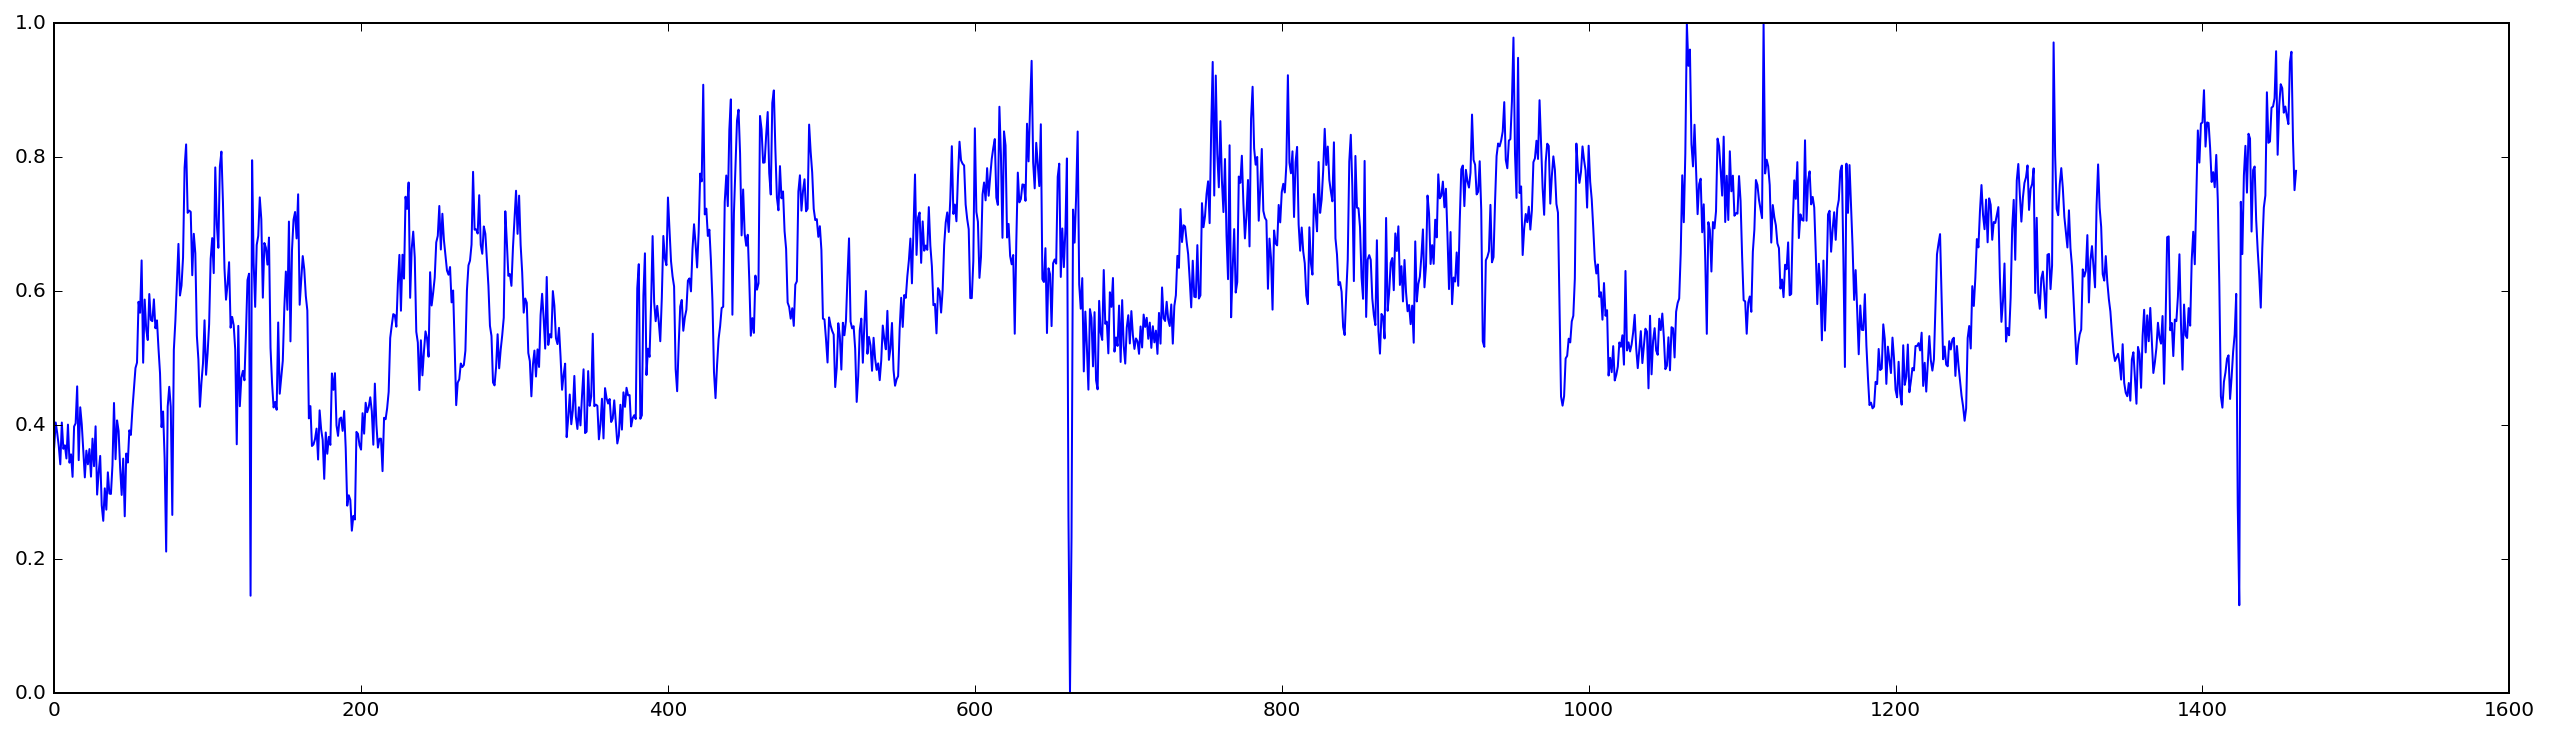

In [17]:
plt.figure(figsize=(22,6), dpi=80)
plt.plot(dataset)

In [18]:


import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

numpy.random.seed(7)
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility


# load the dataset

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Using TensorFlow backend.


TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [ ]:

import tensorflow as tf
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

In [19]:
import keras
keras.__version__


'2.0.5'

In [1]:
!pip uninstall -y tensorflow

Uninstalling tensorflow-0.12.1:
Exception:
Traceback (most recent call last):
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/shutil.py", line 538, in move
    os.rename(src, real_dst)
OSError: [Errno 18] Invalid cross-device link: '/usr/local/src/conda3_runtime.v11/4.1.1/bin/tensorboard' -> '/gpfs/fs01/user/sffc-3691fbb0f320c6-8c20818cd6ff/notebook/tmp/pip-47v91ony-uninstall/usr/local/src/conda3_runtime.v11/4.1.1/bin/tensorboard'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/pip/commands/uninstall.py", line 76, in run
    requirement_set.uninstall(auto_confirm=options.yes)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/pip/req/req_set.py", line 336, in uninstall
    req.uninst

In [2]:
!pip uninstall -y tensorflow

Uninstalling tensorflow-0.12.1:
Exception:
Traceback (most recent call last):
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/shutil.py", line 538, in move
    os.rename(src, real_dst)
OSError: [Errno 18] Invalid cross-device link: '/usr/local/src/conda3_runtime.v11/4.1.1/bin/tensorboard' -> '/gpfs/fs01/user/sffc-3691fbb0f320c6-8c20818cd6ff/notebook/tmp/pip-_udlnr47-uninstall/usr/local/src/conda3_runtime.v11/4.1.1/bin/tensorboard'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/pip/commands/uninstall.py", line 76, in run
    requirement_set.uninstall(auto_confirm=options.yes)
  File "/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/pip/req/req_set.py", line 336, in uninstall
    req.uninst